In [250]:
%load_ext autoreload
%autoreload 2
from utils import *
import itertools
from IPython.display import display, HTML
from scipy.stats import spearmanr
from scipy.stats import pearsonr
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare data

In [93]:
wigler_fam_info = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/Supplementary_Table_1.xlsx")
famID2Gender = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandGender"].values))
famID2VIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandVIQ"].values))
famID2NVIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandNVIQ"].values))

#FSIQ
core_desc = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_core_descriptive.csv")
core_desc = core_desc[["individual", "ssc_diagnosis_full_scale_iq",
                       "ssc_diagnosis_nonverbal_iq", "ssc_diagnosis_verbal_iq"]]
core_desc["familyId"] = core_desc.apply(lambda row:int(row["individual"].split(".")[0]), axis=1)
#display(core_desc.head(2))
core_desc.columns.values
famID2FSIQ = dict(zip(core_desc["familyId"].values, core_desc["ssc_diagnosis_full_scale_iq"].values))

#VABS
VABS_df = pd.read_csv("/Users/jiayao/Work/BrainDisorders/VIP_phenotype/SSC_PhenotypeV15.2/Proband_Data/ssc_proband_vineland_ii.csv")
VABS_df.head()
scores = VABS_df["composite_standard_score"].values
fams = VABS_df["individual"].values
fams = [int(x.split(".")[0]) for x in fams]
famID2VABS = dict(zip(fams, scores))

In [94]:
#Variants = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014RecProLGD.xlsx")
Variants = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProLGD.xlsx")
Variants = Variants[['familyId','vcfVariant','inChild','effectGene','effectType']]
Variants['gender'] = Variants.apply (lambda row: famID2Gender[row["familyId"]], axis=1)
Variants['VIQ'] = Variants.apply (lambda row: famID2VIQ[row["familyId"]], axis=1)
Variants['NVIQ'] = Variants.apply (lambda row: famID2NVIQ[row["familyId"]], axis=1)
Variants['FSIQ'] = Variants.apply (lambda row: famID2FSIQ.get(row["familyId"],-1), axis=1)
Variants['VABS'] = Variants.apply (lambda row: famID2VABS.get(row["familyId"],-1), axis=1)

In [95]:
Variants[Variants["effectGene"]=="KMT2E"]
Variants.loc[Variants["effectGene"]=="KMT2E", "effectGene"] = "MLL5" 

In [96]:
Variants = Variants[~Variants["effectGene"].isin(["ZC3H4"])]
Variants.shape

(389, 10)

In [97]:
AllGenes = set(Variants["effectGene"].values)
print(len(AllGenes))

351


In [98]:
Chrs = [x.split(":")[0] for x in Variants["vcfVariant"].values]
Genes = Variants["effectGene"].values
gene2chr = dict(zip(Genes, Chrs))

In [99]:
# Check same gene same proband
for gene in list(AllGenes):
    tmp = Variants[Variants["effectGene"] == gene]
    if len(set(tmp["familyId"])) != tmp.shape[0]:
        print(gene)
        display(tmp)

In [100]:
gene_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/columns_metadata.csv")
gene_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/gene_matrix/rows_metadata.csv")
display(gene_exp_col.head(2))
display(gene_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name
0,1,13058,H376.IIA.51,8 pcw,M,10268,Ocx,occipital neocortex
1,2,13058,H376.IIA.51,8 pcw,M,10291,M1C-S1C,primary motor-sensory cortex (samples)


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id
0,1,7062.0,ENSG00000000003,TSPAN6,7105.0
1,2,40735.0,ENSG00000000005,TNMD,64102.0


In [101]:
exon_exp_col = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv")
exon_exp_row = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv")
cds_dict = loaddict()
exon_exp_row["exon length"] = exon_exp_row["end"] - exon_exp_row["start"]
exon_exp_row["cds length"] = exon_exp_row.apply(lambda row: addcds(row, cds_dict), axis=1)
exon_exp_col["Period"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
exon_exp_col["Stage"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
exon_exp_col["Description"] = exon_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
gene_exp_col["Period"] = gene_exp_col.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
display(exon_exp_col.head(2))
display(exon_exp_row.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,108


In [102]:
qn_gene_exp_recgenes = pd.read_csv("unifiedmodel/LGDGenes_exp_matrix.csv")
qn_exon_exp_recgenes = pd.read_csv("unifiedmodel/LGDExons_exp_matrix.csv")

In [103]:
exon_exp_row_recgenes = exon_exp_row[exon_exp_row["gene_symbol"].isin(AllGenes)]
exon_exp_row_recgenes["rel.exp"] = 0.0
exon_exp_row_recgenes["isLastExon"] = "F"
for i, row in exon_exp_row_recgenes.iterrows():
    gene, exonId = row["gene_symbol"], row["row_num"]
    gene_index = gene_exp_row[gene_exp_row["gene_symbol"]==gene]["row_num"].values[0]
    GeneExp = qn_gene_exp_recgenes[qn_gene_exp_recgenes["index"]==gene_index].values[0][1:]
    ExonExp = qn_exon_exp_recgenes[qn_exon_exp_recgenes["index"]==exonId].values[0][1:]
    #print(GeneExp[:5], ExonExp[:5])
    gene_amean, exon_amean = np.mean(GeneExp), np.mean(ExonExp)
    #gene_gmean, exon_gmean = sudogmean(GeneExp), sudogmean(ExonExp)
    exon_exp_row_recgenes.at[i, "rel.exp"] = exon_amean/gene_amean
    try:
        if gene != exon_exp_row_recgenes.at[i+1, "gene_symbol"]:
            exon_exp_row_recgenes.at[i, "isLastExon"] = "T"
    except:
        exon_exp_row_recgenes.at[i, "isLastExon"] = "T"
#exon_exp_row_recgenes = exon_exp_row_recgenes[exon_exp_row_recgenes["isLastExon"]=="F"]

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [104]:
exon_exp_row_recgenes["Chr"] = exon_exp_row_recgenes.apply(lambda row: gene2chr[row["gene_symbol"]], axis=1 )
exon_exp_row_recgenes.head()

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,rel.exp,isLastExon,Chr
1248,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,1.188120,F,7
1249,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,1.051193,F,7
1250,1251,1086943,ENSG00000005108,THSD7A,221981.0,11418696,11418907,211,211,1.168342,F,7
1251,1252,1086943,ENSG00000005108,THSD7A,221981.0,11419256,11419382,126,126,0.781333,F,7
1252,1253,1086943,ENSG00000005108,THSD7A,221981.0,11422147,11422243,96,96,1.098260,F,7


In [105]:
exon_exp_row_recgenes.to_csv("unifiedmodel/exon_exp_row_lgdgenes.csv", index=False)

In [106]:
exon_exp_row_recgenes_phyloP = pd.read_csv("unifiedmodel/exon_exp_row_lgdgenes.phyloP.csv")
exon_exp_row_recgenes_phyloP.set_index('row_num', inplace=True)
exon_exp_row_recgenes_phyloP.head(2)

,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,rel.exp,isLastExon,Chr,phyloP100way,phastCons100way
row_num,,,,,,,,,,,,,
1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,1.188120,F,7,0.793141,0.296318
1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,1.051193,F,7,5.170170,0.977000


In [107]:
Prenatal = Stages[:6]
Postnatal = Stages[6:]
PrenatalGeneCols = gene_exp_col[gene_exp_col["Period"].isin(Prenatal)]["column_num"].values
PostnatalGeneCols = gene_exp_col[gene_exp_col["Period"].isin(Postnatal)]["column_num"].values
PrenatalExonCols = exon_exp_col[exon_exp_col["Period"].isin(Prenatal)]["column_num"].values
PostnatalExonCols = exon_exp_col[exon_exp_col["Period"].isin(Postnatal)]["column_num"].values
print(PrenatalGeneCols[-1], PrenatalExonCols[-1])
#print(PrenatalGeneCols, PostnatalGeneCols)

237 237


In [108]:
domain_Jon = pd.read_csv("unifiedmodel/mut-domains.csv")
domain_Jon.set_index('KEY', inplace=True)
display(domain_Jon.head(2))
gerp_Jon = pd.read_csv("unifiedmodel/mut-gerp.csv")
gerp_Jon.set_index('KEY', inplace=True)
display(gerp_Jon.head(2))
#domain_Jon.loc["14075-1:3519050"]["DOM.TRUNC.FRAC"]
SSC_proband_metadata = pd.read_csv("/Users/jiayao/Work/BrainDisorders/JW/SSC_proband_metadata.csv")
DEVEL = "/Users/jiayao/Work/BrainDisorders/JW/Functional_Cluster_Gene_Lists/Cluster_DEVEL.txt"
NEURO = "/Users/jiayao/Work/BrainDisorders/JW/Functional_Cluster_Gene_Lists/Cluster_NEURO.txt"
neuronal = [l.strip() for l in open(NEURO, 'rt')]
develop  = [l.strip() for l in open(DEVEL, 'rt')]
print(len(neuronal), len(develop))

,DOM.TRUNC,DOM.KEPT,DOM.TRUNC.N,DOM.KEPT.N,DOM.TRUNC.FRAC
KEY,,,,,
11563-1:1222518,PF00858,NaN,1.0,0.0,1.0
14075-1:3519050,PF00053 PF07645 PF14670,NaN,3.0,0.0,1.0


,ensembl_exon_id,ensembl_transcript_id,ensembl_gene_id,chromosome_name,exon_chrom_start,exon_chrom_end,entrezgene,CONSERV
KEY,,,,,,,,
11563-1:1222518,ENSE00003620052,ENST00000338555,ENSG00000162572,1,1222489.0,1222679.0,6339.0,0.296541
14075-1:3519050,ENSE00001477190,ENST00000356575,ENSG00000162591,1,3519030.0,3519164.0,1953.0,1.888373


137 123


In [109]:
SSC_proband_metadata["famid"] = SSC_proband_metadata.apply(lambda row:row[0].split(".")[0], axis=1)
famid2age = dict(zip(SSC_proband_metadata["famid"].values, SSC_proband_metadata["age"].values))
SSC_proband_metadata.head()

,individual,family,age,sex,famid
0,11000.p1,quad,110,male,11000
1,11001.p1,trio,93,male,11001
2,11002.p1,quad,92,female,11002
3,11004.p1,quad,190,male,11004
4,11010.p1,quad,49,male,11010


In [110]:
def sudogmean(values):
    #values = [math.log2(x+1) for x in values]
    #gmean = np.mean(values)
    #return math.pow(2, gmean)
    values = [(x+1) for x in values]
    gmean = scipy.stats.mstats.gmean(values)
    return gmean-1
def searchExon(Gene, Chr, Pos, Ref, Alt, ExonExp, ExonRow, ExonCol):
    Pos, LenV = int(Pos), len(Ref)-len(Alt)
    ExonRow = ExonRow[ExonRow["gene_symbol"]==Gene]
    ith = 1
    for i, row in ExonRow.iterrows():
        row_num, start, end = row["row_num"],int(row["start"]),int(row["end"])
        #print(Pos, start, end)
        if Pos > start -3 and Pos < end + 3:
            if ith == ExonRow.shape[0]:
                return row_num, "Y"
            else:
                return row_num, "N"
        elif LenV > 0: # a delition may span a splice site
            if (Pos < start-3 and Pos + LenV > start ) or (Pos < end and Pos + LenV > end +3):
                if ith == ExonRow.shape[0]:
                    return row_num, "Y"
                else:
                    return row_num, "N"
        ith += 1
    return 0, "0"
def FunctionalGrouping(gene):
    if gene in neuronal:
        return 1
    elif gene in develop:
        return 2
    else:
        return 0
def DOM_TRUNC(X):
    if pd.isnull(X):
        return 0
    else:
        return 1

Variants["ExonID"] = 0
Variants["LastExon"] = "N"
Variants["GeneExp.amean"] = 0.0
Variants["GeneExp.gmean"] = 0.0
Variants["ExonExp.amean"] = 0.0
Variants["ExonExp.gmean"] = 0.0
Variants["GenePrenatalExp.amean"] = 0.0
Variants["GenePrenatalExp.gmean"] = 0.0
Variants["ExonPrenatalExp.amean"] = 0.0
Variants["ExonPrenatalExp.gmean"] = 0.0
Variants["GenePostnatalExp.amean"] = 0.0
Variants["GenePostnatalExp.gmean"] = 0.0
Variants["ExonPostnatalExp.amean"] = 0.0
Variants["ExonPostnatalExp.gmean"] = 0.0
Variants["phyloP100way"] = 0.0
for i, row in Variants.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    Variants.at[i, "Functional"] = FunctionalGrouping(gene)
    try:
        Variants.at[i, "Age"] = famid2age[str(famid)]
    except:
        Variants.at[i, "Age"] = 0
    try:
        GeneExp = qn_gene_exp_recgenes[qn_gene_exp_recgenes["index"]==
                                       gene_exp_row[gene_exp_row["gene_symbol"]==gene]["row_num"].values[0]].values[0][1:]
    except IndexError:
        print("gene not find", famid, gene)
    #print(np.mean(GeneExp), scipy.stats.mstats.gmean(GeneExp), sudogmean(GeneExp))
    GeneExpPre, GeneExpPost = GeneExp[1:238], GeneExp[238:]
    #GeneExp = [x for x in GeneExp if x != 0]
    #GeneExpPre = [x for x in GeneExpPre if x != 0]
    #GeneExpPre = [x for x in GeneExpPre if x != 0]
    gene_nmean, gene_gmean = np.mean(GeneExp), sudogmean(GeneExp)
    Variants.at[i, "GeneExp.amean"] = gene_nmean
    Variants.at[i, "GeneExp.gmean"] = gene_gmean
    exonId, LastExon = searchExon(gene, Chr, Pos, Ref, Alt, qn_exon_exp_recgenes, exon_exp_row, exon_exp_col)
    if len(Ref) == len(Alt):
        Variants.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos))
        Variants.at[i, "DOM.TRUNC.FRAC"] = domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["DOM.TRUNC.FRAC"]
        Variants.at[i, "DOM.TRUNC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["DOM.TRUNC"])
        Variants.at[i, "GERP"] = gerp_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos))]["CONSERV"]
    else:
        Variants.at[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos)+1)
        Variants.at[i, "DOM.TRUNC.FRAC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["DOM.TRUNC.FRAC"])
        Variants.at[i, "DOM.TRUNC"] = DOM_TRUNC(domain_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["DOM.TRUNC"])
        Variants.at[i, "GERP"] = gerp_Jon.loc["%s-%s:%d"%(famid, Chr, int(Pos)+1)]["CONSERV"]
    if exonId != 0:
        Variants.at[i, "ExonID"] = exonId
        Variants.at[i, "LastExon"] = LastExon
        ExonExp = qn_exon_exp_recgenes[qn_exon_exp_recgenes["index"]==exonId].values[0][1:]
        ExonExpPre, ExonExpPost = ExonExp[1:238], ExonExp[238:]
        
        exon_nmean, exon_gmean = np.mean(ExonExp), sudogmean(ExonExp)
        Variants.at[i, "ExonExp.amean"] = exon_nmean
        Variants.at[i, "ExonExp.gmean"] = exon_gmean
        Variants.at[i, "ExonPrenatalExp.amean"] = np.mean(ExonExpPre)
        Variants.at[i, "ExonPrenatalExp.gmean"] = sudogmean(ExonExpPre)
        Variants.at[i, "ExonPostnatalExp.amean"] = np.mean(ExonExpPost)
        Variants.at[i, "ExonPostnatalExp.gmean"] = sudogmean(ExonExpPost)
        Variants.at[i, "Rel.exp.amean"] = exon_nmean/gene_nmean
        Variants.at[i, "Rel.exp.gmean"] = exon_gmean/gene_gmean
        
        Variants.at[i, "Rel.exp.prenatal"] = np.mean(ExonExpPre)/np.mean(GeneExpPre)
        Variants.at[i, "Rel.exp.postnatal"] = np.mean(ExonExpPost)/np.mean(GeneExpPost)
        try:
            Variants.at[i, "Prenatal.Bias"] = math.log2(np.mean(ExonExpPre)/np.mean(ExonExpPost))
        except ValueError:
            Variants.at[i, "Prenatal.Bias"] = 0
        #if LastExon == "N":
        Variants.at[i, "phyloP100way"] = exon_exp_row_recgenes_phyloP.loc[exonId]["phyloP100way"]
        Variants.at[i, "phastCons100way"] = exon_exp_row_recgenes_phyloP.loc[exonId]["phastCons100way"]
    else:
        print("exon not find", famid, gene)

exon not find 11208 C16orf13
gene not find 14575 CCDC171
exon not find 14575 CCDC171
gene not find 12563 CCPG1
exon not find 12563 CCPG1
gene not find 13548 GALNT18
exon not find 13548 GALNT18
gene not find 13861 KIR2DL2
exon not find 13861 KIR2DL2
gene not find 11145 KMT2A
exon not find 11145 KMT2A
gene not find 11148 KMT2C
exon not find 11148 KMT2C
gene not find 13590 MTHFS,ST20-MTHFS
exon not find 13590 MTHFS,ST20-MTHFS
gene not find 14473 NXPE4
exon not find 14473 NXPE4


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in double_scalars


gene not find 11925 SKIDA1
exon not find 11925 SKIDA1


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:100: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in double_scalars
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: invalid value encountered in double_scalars


gene not find 14644 UGT1A10,UGT1A8,UGT1A9,UGT1A4,UGT1A5,UGT1A6,UGT1A7,UGT1A1,UGT1A3
exon not find 14644 UGT1A10,UGT1A8,UGT1A9,UGT1A4,UGT1A5,UGT1A6,UGT1A7,UGT1A1,UGT1A3
gene not find 13913 ZNF853
exon not find 13913 ZNF853


In [136]:
def mapgender(row):
    if row["gender"] == "M": 
        return 1
    elif row["gender"] == "F":
        return 2
Variants["gender1"] = Variants.apply(lambda row:mapgender(row), axis=1)
Variants.head()
VariantsOut = Variants[['KEY','familyId', 'vcfVariant', 'inChild', 'effectGene', 'effectType',
       'gender', 'FSIQ', 'VIQ', 'NVIQ', 'VABS', 'ExonID', 'GeneExp.amean', 'ExonExp.amean',
       'GenePrenatalExp.amean', 'ExonPrenatalExp.amean', 'GenePostnatalExp.amean', 'ExonPostnatalExp.amean', 
       'Functional', 'DOM.TRUNC.FRAC','DOM.TRUNC', 'GERP', 'Rel.exp.amean','Rel.exp.gmean',
       'Rel.exp.prenatal', 'Rel.exp.postnatal', 'Prenatal.Bias',
       'phyloP100way', 'phastCons100way', 'gender1', 'Age']]
VariantsOut.to_csv("unifiedmodel/features.jiayao.65.csv", index=False)
Variants.to_csv("unifiedmodel/SSC.LGD.features.csv", index="False")

In [137]:
tmpdf = Variants[np.isfinite(Variants['phyloP100way'])]
tmpdf = tmpdf[np.isfinite(tmpdf['NVIQ'])]

In [138]:
r, p = spearmanr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)
r, p = pearsonr(np.array(tmpdf["phyloP100way"]), np.array(tmpdf["NVIQ"]))
print(r,p)

-0.16035774720792725 0.0015295285798677255
-0.13485497767684795 0.007815801504331771


In [139]:
GeneCount = Variants.groupby("effectGene")["effectGene"].count()
Variants["GeneCount"] = Variants.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Variants = Variants[Variants["GeneCount"]>=2]
Variants[Variants["LastExon"]=="Y"]

,familyId,vcfVariant,inChild,effectGene,effectType,gender,VIQ,NVIQ,FSIQ,VABS,...,DOM.TRUNC,GERP,Rel.exp.amean,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phastCons100way,gender1,GeneCount
26,13447,6:157527664:CTGTT:C,pF,ARID1B,frame-shift,F,32.0,51.0,44.0,58.0,...,1.0,2.284661,2.717545,2.844262,2.516281,3.028648,0.730105,0.875879,2,2
255,12323,9:96439929:AT:A,pM,PHF2,frame-shift,M,92.0,90.0,90.0,83.0,...,0.0,2.572848,1.141488,1.181713,1.015046,1.393761,0.843528,0.654036,1,2
331,13796,2:162275481:A:AC,pF,TBR1,frame-shift,F,69.0,63.0,61.0,73.0,...,1.0,4.266059,0.960084,1.046558,0.937590,1.078703,2.341579,0.482697,2,2


In [140]:
#Variants = Variants[~Variants["familyId"].isin(LastExonFamilID)]
GeneCount = Variants.groupby("effectGene")["effectGene"].count()
Variants["GeneCount"] = Variants.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Variants = Variants[Variants["GeneCount"]>=2]
print(Variants.shape[0])

65


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [141]:
Variants[Variants["Functional"]==0].shape

(10, 39)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jiayao/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


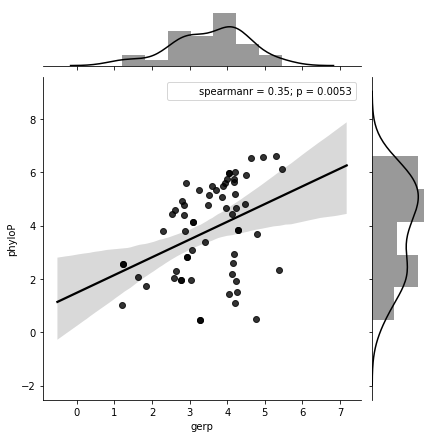

In [142]:
gerp = list(Variants["GERP"].values[:16]) + list(Variants["GERP"].values[18:])
phyloP = list(Variants["phyloP100way"].values[:16]) + list(Variants["phyloP100way"].values[18:])
j = sns.jointplot(x=gerp, y=phyloP, kind='reg', color="black")
j.annotate(spearmanr)
plt.xlabel("gerp")
plt.ylabel("phyloP")
plt.show()

In [143]:
#Variants = Variants[Variants["familyId"]!=13900]
gene2slope = {}
ALL_RelExp = np.array([])
ALL_Normed_IQD = np.array([])
Genes = list(set(Variants["effectGene"].values))
for gene in Genes:
    df = Variants[Variants["effectGene"]==gene]
    IQs = [max(0, (100-x)) for x in df["NVIQ"].values]
    #rel_exps = [x for x in df["Rel.exp.amean"].values] #Rel.exp.prenatal
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    regr = regGene(rel_exps, IQs)
    slope = regr.coef_[0]
    #if slope == 0:
    #    continue
    gene2slope[gene] = slope
    ALL_RelExp = np.append(ALL_RelExp, rel_exps)
    NormIQDs = np.array([x/slope for x in IQs])
    ALL_Normed_IQD = np.append(ALL_Normed_IQD, NormIQDs)

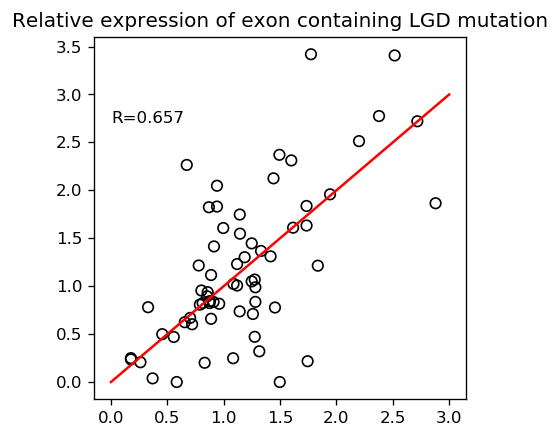

In [144]:
model = linear_model.LinearRegression(fit_intercept=False)
ALL_RelExp = ALL_RelExp.reshape(-1,1)
R, P = scipy.stats.pearsonr([x[0] for x in ALL_RelExp], ALL_Normed_IQD) 
plt.figure(figsize=(4,4), dpi=120)
plt.title("Relative expression of exon containing LGD mutation")
model.fit(ALL_RelExp, ALL_Normed_IQD)
plt.scatter(ALL_RelExp, ALL_Normed_IQD, s=40, facecolors='none', edgecolors='black')
plt.plot([0, 3], [0,model.predict([[3.0]])], color='red')
plt.text(0, 2.7, "R=%.3f"%(R))
plt.show()

In [145]:
def cdf(weights):
    total = sum(weights)
    result = []
    cumsum = 0
    for w in weights:
        cumsum += w
        result.append(cumsum / total)
    return result
def choice(population, weights):
    assert len(population) == len(weights)
    cdf_vals = cdf(weights)
    x = random.random()
    idx = bisect.bisect(cdf_vals, x)
    return population[idx]
def GetExonProb(exon_df):
    Total_length = sum(exon_df["cds length"].values)
    Probs = [float(x)/Total_length for x in exon_df["cds length"].values]
    return exon_df.index.values, Probs

68.32307692307693
(65, 39)
12752 CHD8 93.0 [27.83118645] 1.7445203292022404
13900 CHD8 27.0 [80.47699445] 0.672300850348769
11403 FOXP1 64.0 0 2.879538174647055
12952 MLL5 58.0 0 1.4159638594755717


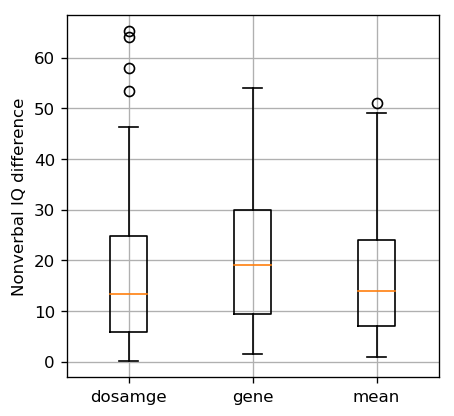

65 [-0.35798041] -0.43448070584448173 [0.05332961]
Mean
(65, 40)


In [146]:
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
SSE1, SSE2, SSE3 = 0,0,0
avg_IQ = np.mean(Variants["NVIQ"].values)
print(avg_IQ)
N = 0
ExcludeList = []
#Variants = Variants[Variants["familyId"]!=13900]
print(Variants.shape)
for i, row in Variants.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    #familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.prenatal"], row["NVIQ"]
    df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.gmean"].values]
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(familyId, gene, IQ, IQpre_dosage, ralexp)
    #    Variants.at[i, "Dosage"] = IQpre_dosage
    #    ExcludeList.append(familyId)
    #    continue
    Variants.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1
plt.figure(figsize=(4,4), dpi=120)
plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
plt.ylabel("Nonverbal IQ difference")
plt.grid(True)
plt.show()
print(N, (1-SSE1/SSE3),(1-SSE2/SSE3),(1-SSE1/SSE2))
print("Mean")
print(Variants.shape)

In [147]:
VariantsOut = Variants[['KEY','familyId', 'vcfVariant', 'inChild', 'effectGene', 'effectType',
       'gender', 'FSIQ', 'VIQ', 'NVIQ', 'VABS', 'ExonID', 'GeneExp.amean', 'ExonExp.amean',
       'GenePrenatalExp.amean', 'ExonPrenatalExp.amean', 'GenePostnatalExp.amean', 'ExonPostnatalExp.amean', 
       'Functional', 'DOM.TRUNC.FRAC','DOM.TRUNC', 'GERP', 'Rel.exp.amean','Rel.exp.gmean',
       'Rel.exp.prenatal', 'Rel.exp.postnatal', 'Prenatal.Bias',
       'phyloP100way', 'phastCons100way', 'gender1', 'Age', 'Dosage']]
VariantsOut.to_csv("unifiedmodel/features.jiayao.65.csv", index=False)

In [148]:
gerp = list(Variants["GERP"].values[:16]) + list(Variants["GERP"].values[18:])
tmpIQs = list(Variants["NVIQ"].values[:16]) + list(Variants["NVIQ"].values[18:])
r, p = pearsonr(np.array(gerp), np.array(tmpIQs))
print("GERP", r, p)

GERP nan 1.0


In [149]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
Jiayao_features.head(2)

,KEY,familyId,vcfVariant,inChild,effectGene,effectType,gender,FSIQ,VIQ,NVIQ,...,Rel.exp.amean,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phyloP100way,phastCons100way,gender1,Age,Dosage
0,13545-20:49509095,13545,20:49509094:G:GT,pM,ADNP,frame-shift,M,30.0,23.0,38.0,...,1.248356,1.29008,1.215442,1.32567,1.423534,2.813101,0.732081,1,61.0,56.455400
1,12130-20:49510028,12130,20:49510027:CTT:C,pF,ADNP,frame-shift,F,54.0,62.0,55.0,...,1.248356,1.29008,1.215442,1.32567,1.423534,2.813101,0.732081,2,101.0,40.005218


In [150]:
ExcludeList = ["13398-1:151377904", "13627-1:151378489", "13664-1:202698172", "13447-6:157527665", 
               "12323-9:96439930", "13545-20:49509095", "12130-20:49510028", "12764-2:183791570", "13735-21:41414331"]
#ExcludeList = []
Jiayao_features = Jiayao_features[~Jiayao_features["KEY"].isin(ExcludeList)]
GeneCount = Jiayao_features.groupby("effectGene")["effectGene"].count()
Jiayao_features["GeneCount"] = Jiayao_features.apply(lambda row: GeneCount[row["effectGene"]], axis=1)
Jiayao_features = Jiayao_features[Jiayao_features["GeneCount"]>=2]
print(Jiayao_features.shape)

(52, 33)


In [151]:
Jiayao_features.to_csv("unifiedmodel/features.jiayao.52.csv", index=False)

In [152]:
FamExclude = [12673, 13319, 12681, 12810, 11403, 12044, 12817, 13844, 
              14486, 12952, 12703, 12323, 12324, 13094, 13735, 14376, 
              12329, 11178, 11691, 12969, 13614, 13618, 12600, 12090, 
              13885, 12991, 14016, 11329, 13890, 14530, 13000, 13256, 
              14030, 13903, 12624, 12752, 13012, 13398, 11480, 12507, 
              14299, 11872, 12645, 14183, 11114, 13552, 14327, 11003,]
FamExcludeCadd20 = [int(x.strip()) for x in open("unifiedmodel/cadd.20.list", 'rt')]
FamExcludeCadd30 = [int(x.strip()) for x in open("unifiedmodel/cadd.30.list", 'rt')]

In [153]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
#Jiayao_features = Jiayao_features[Jiayao_features["gender"]=="M"]
Jiayao_features_without_mis = Jiayao_features[~Jiayao_features["familyId"].isin(FamExclude)]
Jiayao_features_with_mis = Jiayao_features[Jiayao_features["familyId"].isin(FamExclude)]
print(Jiayao_features.shape)
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
avg_IQ = np.mean(Jiayao_features["NVIQ"].values)
print(avg_IQ)
N,n = 0,0
for i, row in Jiayao_features_without_mis.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    df = Jiayao_features[(Jiayao_features["effectGene"]==gene) & (Jiayao_features["familyId"]!=familyId)]
    #df = Jiayao_features_without_mis[(Jiayao_features_without_mis["effectGene"]==gene) & (Jiayao_features_without_mis["familyId"]!=familyId)]
    if df.shape[0] < 1:
        continue
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0][0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 40:
        print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
        #Jiayao_features.at[i, "Dosage"] = IQpre_dosage
        #ExcludeList.append(familyId)
        #continue
    Jiayao_features_without_mis.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    N += 1
print(N)

(52, 33)
68.25
13900-14:21895990 CHD8 27.0 80.26547976838384 0.672300850348769
23


In [154]:
IQ_diff4, IQ_diff5, IQ_diff6 = [], [], []
N = 0
for i, row in Jiayao_features_with_mis.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    df = Jiayao_features[(Jiayao_features["effectGene"]==gene) & (Jiayao_features["familyId"]!=familyId)]
    #df = Jiayao_features_with_mis[(Jiayao_features_with_mis["effectGene"]==gene) & (Jiayao_features_with_mis["familyId"]!=familyId)]
    if df.shape[0] < 1:
        continue
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0][0]
    IQpre_dosage = max(0, (100 - slope * ralexp))
    
    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
    Jiayao_features_with_mis.at[i, "Dosage"] = IQpre_dosage
    IQ_diff4.append(abs(IQ - IQpre_dosage))
    IQ_diff5.append(abs(IQ - IQpre_gene))
    IQ_diff6.append(abs(IQ - 70))
    N += 1
    
print(N)
#scipy.stats.ks_2samp(IQ_diff2, IQ_diff5)
print( "W/O Mis:%.2f %.2f %.2f\nW/ Mis: %.2f %.2f %.2f" % 
      (np.mean(IQ_diff1), np.mean(IQ_diff2), np.mean(IQ_diff3), 
       np.mean(IQ_diff4), np.mean(IQ_diff5), np.mean(IQ_diff6)))
t1, p1 = scipy.stats.mannwhitneyu(IQ_diff1, IQ_diff4)
t2, p2 = scipy.stats.mannwhitneyu(IQ_diff2, IQ_diff5)
t3, p3 = scipy.stats.mannwhitneyu(IQ_diff3, IQ_diff6)
print(p1,p2,p3)

12752-14:21861377 CHD8 93.0 27.87568177809308 1.7445203292022404
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12952-7:104748101 MLL5 58.0 0 1.4159638594755717
29
W/O Mis:14.16 20.34 19.09
W/ Mis: 21.13 20.07 14.90
0.11913879041585484 0.44500050043620576 0.17815629814428136


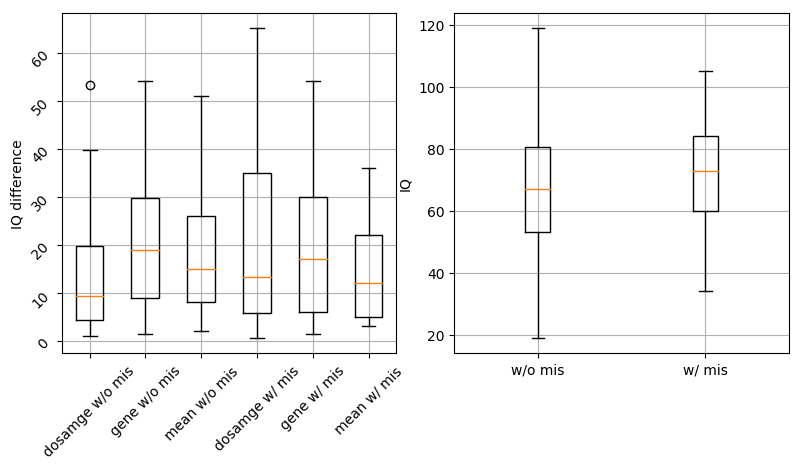

In [155]:
fig, ax = plt.subplots(1,2, figsize=(8,4), dpi=100,)
fig.tight_layout()
ax[0].boxplot([IQ_diff1, IQ_diff2, IQ_diff3]+[IQ_diff4, IQ_diff5, IQ_diff6], 
            labels = ["dosamge w/o mis", "gene w/o mis", "mean w/o mis"]+
            ["dosamge w/ mis", "gene w/ mis", "mean w/ mis"])
ax[0].tick_params(labelrotation=45)
ax[0].set_ylabel("IQ difference")
ax[0].grid(True)
ax[1].boxplot([Jiayao_features_without_mis["NVIQ"], Jiayao_features_with_mis["NVIQ"]],
            labels = ["w/o mis", "w/ mis"])
ax[1].grid(True)
ax[1].set_ylabel("IQ")
plt.show()

In [156]:
df = Jiayao_features_without_mis
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
#GLMs.append(res)
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
               "phyloP100way", "Functional", "DOM.TRUNC", "gender1", "Prenatal.Bias"]:
#    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    #GLMs.append(res)
    pred = res.predict(X)
print(PredErrMedian(pred, Y))
print(res.summary())

9.481633467150019
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   23
Model:                            GLM   Df Residuals:                       14
Model Family:                Gaussian   Df Model:                            8
Link Function:               identity   Scale:                          454.03
Method:                          IRLS   Log-Likelihood:                -97.286
Date:                Mon, 08 Jul 2019   Deviance:                       6356.5
Time:                        12:05:00   Pearson chi2:                 6.36e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3005     53.434      0.268      0.789     -90.429     119.030
x1             0.7723      0.395  

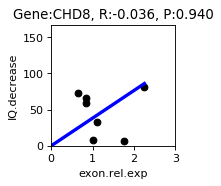

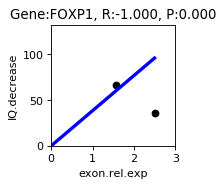

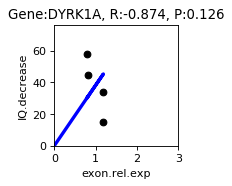

In [157]:
def plotGene(gene, dat):
    dat = dat[dat["effectGene"]==gene]
    X_train = np.array(dat["Rel.exp.gmean"].values)
    IQs = dat["NVIQ"].values
    y_train = np.array([max(0, (100-x)) for x in IQs])
    regr = regGene(rel_exps, IQDiffs)
    y_pred = regr.predict(np.reshape(X_train, (-1,1)))
    R, P = scipy.stats.pearsonr(X_train, y_train)
    plt.figure(figsize=(2,2), dpi=80)
    plt.title("Gene:%s, R:%.3f, P:%.3f"%(gene, R,P))
    plt.xlim(0,3)
    plt.ylim(0, max(y_train[0]+y_pred[0]))
    plt.scatter(X_train, y_train,  color='black')
    plt.plot(np.append(X_train, [0]), np.append(y_pred, 0), color='blue', linewidth=3)
    plt.xlabel("exon.rel.exp")
    plt.ylabel("IQ.decrease")
    plt.show()
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
plotGene("CHD8", Jiayao_features)
plotGene("FOXP1", Jiayao_features) 
plotGene("DYRK1A", Jiayao_features)

In [158]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
#Jiayao_features = Jiayao_features[~Jiayao_features["familyId"].isin(ExcludeList)]
print(Jiayao_features.shape)
print("%20s\t%8s\t%8s\t%8s\t%8s\t%8s"%("feature", "spearmanr", "P_corr", "R2_gene", "R2_mean", "Mean.Err"))
X = np.array(Jiayao_features["Dosage"].values)

X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(Jiayao_features["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit()
pred = res.predict(X)
r, p = spearmanr(np.array(Jiayao_features["Dosage"]), np.array(Jiayao_features["NVIQ"]))
R2_gene = 1- SSE(pred, Y)/SSE_Gene
R2_mean = 1- SSE(pred, Y)/SSE_Mean
print("%20s\t%8.3f\t%8.2e\t%8.4f\t%8.4f\t%8.4f"%("Dosage", r, p, R2_gene, R2_mean, PredErrMean(pred, Y)))
for feature in []:#["Rel.exp.prenatal", "Rel.exp.postnatal",
                #"phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(Jiayao_features[feature].values), np.array(Jiayao_features["NVIQ"].values))
    x = np.array(Jiayao_features[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    pred = res.predict(X)
    R2_gene = 1- SSE(pred, Y)/SSE_Gene
    R2_mean = 1- SSE(pred, Y)/SSE_Mean
print("%20s\t%8.3f\t%8.2e\t%8.4f\t%8.4f\t%8.4f"%(feature, r, p, R2_gene, R2_mean, PredErrMedian(pred, Y)))
print(res.summary())

(52, 33)
             feature	spearmanr	  P_corr	 R2_gene	 R2_mean	Mean.Err
              Dosage	   0.352	1.06e-02	  0.9876	  0.9825	 15.6476
       Prenatal.Bias	   0.352	1.06e-02	  0.9876	  0.9825	 13.0000
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   52
Model:                            GLM   Df Residuals:                       50
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          403.86
Method:                          IRLS   Log-Likelihood:                -228.79
Date:                Mon, 08 Jul 2019   Deviance:                       20193.
Time:                        12:05:01   Pearson chi2:                 2.02e+04
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
--

In [159]:
#Jiayao_features.to_csv("unifiedmodel/features.jiayao.52.csv", index=False)

12752-14:21861377 CHD8 93.0 27.87568177809308 1.7445203292022404
13900-14:21895990 CHD8 27.0 80.26547976838384 0.672300850348769
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12817-3:71050171 FOXP1 34.0 77.82006481693614 1.77411027974527
12952-7:104748101 MLL5 58.0 0 1.4159638594755717
52


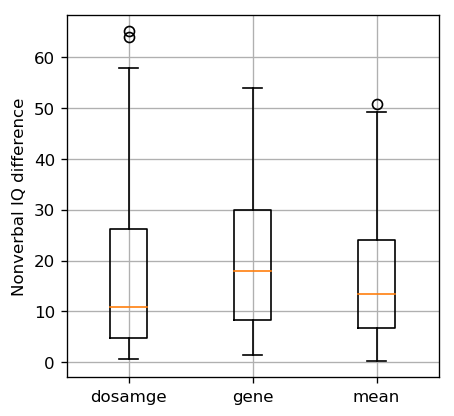

MannwhitneyuResult(statistic=1299.0, pvalue=0.3664249944168407)
MannwhitneyuResult(statistic=1143.5, pvalue=0.08808704573854204)
Mean:	Dosage:18.049	Gene:20.192	Mean:16.683
Median:	Dosage:10.915	Gene:18.000	Mean:13.500


AttributeError: 'tuple' object has no attribute 'shape'

In [160]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
df = DosageModel(Jiayao_features)
df.shape

In [161]:
Addfeatures_singlefeature = []
TestingErrs_singlefeature = []
TestingErrConf_singlefeature = []
for feature in features:
    Addfeatures_singlefeature.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, [feature], Error=Error)
    TestingErrs_singlefeature.append(np.mean(Scores_Test))
    #TestingErrConf_singlefeature.append(np.std(Scores_Test)  / math.sqrt(Fold))
    TestingErrConf_singlefeature.append(abs(Scores_Test[5] - Scores_Test[95])/2)

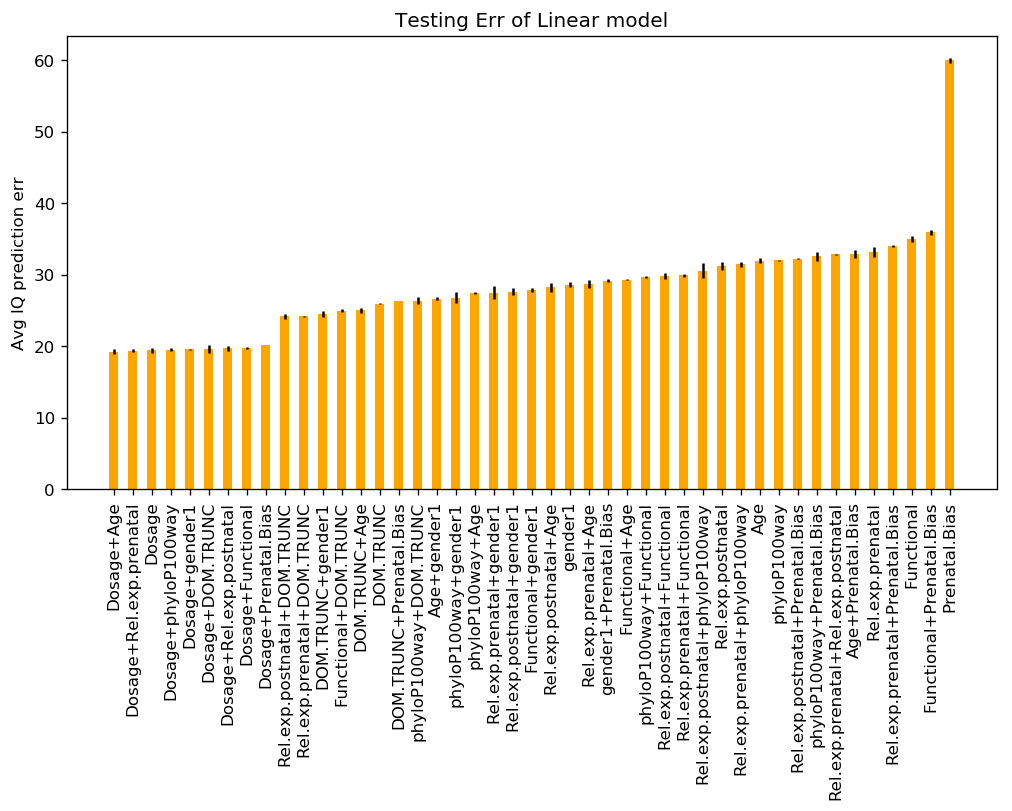

In [162]:
Addfeatures = []
TestingErrs = []
TestingErrConf = []
for feature1, feature2 in itertools.combinations(features, 2):
    #Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, [feature1, feature2], Error=Error)
    Addfeatures.append([feature1, feature2])
    TestingErrs.append(np.mean(Scores_Test))
    #TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(Fold))
    TestingErrConf.append(abs(Scores_Test[5] - Scores_Test[95])/2)
Addfeatures.extend([[x] for x in Addfeatures_singlefeature])
TestingErrs.extend(TestingErrs_singlefeature)
TestingErrConf.extend(TestingErrConf_singlefeature)
tmp = list(zip(Addfeatures, TestingErrs, TestingErrConf))
tmp = sorted(tmp, key=lambda x:x[1])
Addfeatures = [x for x,y,z in tmp]
TestingErrs = [y for x,y,z in tmp]
TestingErrConf = [z for x,y,z in tmp]
x_pos = np.arange(len(Addfeatures))
fig, ax = plt.subplots(figsize=(10,5), dpi=120)
plt.title("Testing Err of Linear model")
ax.bar(x_pos, TestingErrs, 0.5 ,yerr=TestingErrConf, color="orange")
ax.set_xticks(x_pos)
ax.set_xticklabels(["+".join(x) for x in Addfeatures])
plt.ylabel("Avg IQ prediction err")
plt.xticks(rotation=90)
plt.show()

In [163]:
#SameExonIQ
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
ExonCount = Jiayao_features.groupby("ExonID")["ExonID"].count()
Jiayao_features["ExonCount"] = Jiayao_features.apply(lambda row: ExonCount[row["ExonID"]], axis=1)
SameExon = Jiayao_features[Jiayao_features["ExonCount"]>=2]

In [164]:
VIQ_diff, NVIQ_diff = [], []
for exon in list(set(SameExon['ExonID'].values)):
    tmpdf = SameExon[SameExon["ExonID"]==exon]
    VIQs = tmpdf["VIQ"].values
    NVIQs = tmpdf["NVIQ"].values
    VIQ_diff.append(abs(VIQs[0]-VIQs[1]))
    NVIQ_diff.append(abs(NVIQs[0]-NVIQs[1]))

In [165]:
print(np.mean(VIQ_diff), np.mean(NVIQ_diff), 17.25-8.25)
print(scipy.stats.wilcoxon(VIQ_diff, NVIQ_diff))
print(0.0625089161964483/2)

17.25 8.25 9.0
WilcoxonResult(statistic=3.0, pvalue=0.0625089161964483)
0.03125445809822415


/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


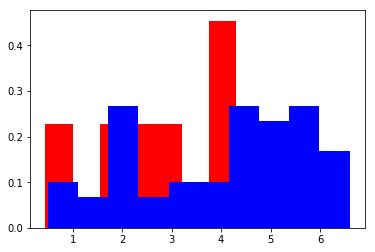

MannwhitneyuResult(statistic=155.0, pvalue=0.17607152321001907)

In [166]:
shared_phy = list(set(SameExon["phyloP100way"].values))
other_phy = list(set(Jiayao_features[Jiayao_features["ExonCount"]==1]["phyloP100way"].values))
plt.hist(shared_phy, color="r", density=1)
plt.hist(other_phy, color="b", density=1)
plt.show()
scipy.stats.mannwhitneyu(shared_phy, other_phy)#, alternative='less')

835.8854437869824 426.12639053254446


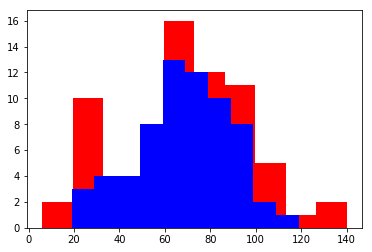

1.961590416266752 0.9960912686552379


In [167]:
VIQs = Jiayao_features["VIQ"].values
NVIQs = Jiayao_features["NVIQ"].values
print(np.var(VIQs), np.var(NVIQs))
plt.hist(VIQs, color="r")
plt.hist(NVIQs, color="b")
plt.show()

F = np.var(VIQs)/np.var(NVIQs)
df1 = len(VIQs) - 1
df2 = len(NVIQs) - 1
p_value = scipy.stats.f.cdf(F, df1, df2)
print(F, p_value)

589.359375 270.25


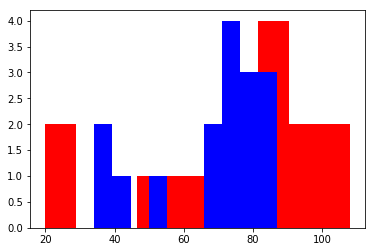

2.1807932469935247 0.9288181390728384
LeveneResult(statistic=0.7884861940648551, pvalue=0.381622541900992)


In [168]:
VIQs = SameExon["VIQ"].values
NVIQs = SameExon["NVIQ"].values
print(np.var(VIQs), np.var(NVIQs))
plt.hist(VIQs, color="r")
plt.hist(NVIQs, color="b")
plt.show()

F = np.var(VIQs)/np.var(NVIQs)
df1 = len(VIQs) - 1
df2 = len(NVIQs) - 1
p_value = scipy.stats.f.cdf(F, df1, df2)
print(F, p_value)
print(scipy.stats.levene(VIQs, NVIQs))

12752-14:21861377 CHD8 93.0 27.87568177809308 1.7445203292022404
13900-14:21895990 CHD8 27.0 80.26547976838384 0.672300850348769
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12817-3:71050171 FOXP1 34.0 77.82006481693614 1.77411027974527
12952-7:104748101 MLL5 58.0 0 1.4159638594755717
52


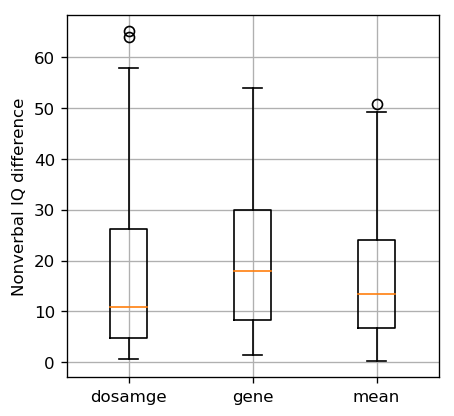

MannwhitneyuResult(statistic=1299.0, pvalue=0.3664249944168407)
MannwhitneyuResult(statistic=1143.5, pvalue=0.08808704573854204)
Mean:	Dosage:18.049	Gene:20.192	Mean:16.683
Median:	Dosage:10.915	Gene:18.000	Mean:13.500
52
52
17.767030790270734
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   52
Model:                            GLM   Df Residuals:                       51
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          603.73
Method:                          IRLS   Log-Likelihood:                -239.76
Date:                Mon, 08 Jul 2019   Deviance:                       30790.
Time:                        12:06:00   Pearson chi2:                 3.08e+04
No. Iterations:                     3   Covariance Type:             nonrobust
                 coef    std err          z  

In [169]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
#Jiayao_features = Jiayao_features[~
#    Jiayao_features["KEY"].isin(["13735-21:41414331","12764-2:183791570","12323-9:96439930"])]
df, pred_dosage, pred_gene, pred_mean, ALL_IQ = DosageModel(Jiayao_features)

print(df.shape[0])
#df = df[abs(df["Dosage"] - df["NVIQ"]) < 50]
print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
#const = np.reshape(  np.ones(X.shape[0]),(-1,1))
#X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
                "phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    #X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    pred = res.predict(X)
print(PredErrMean(pred, Y))
print(res.summary())

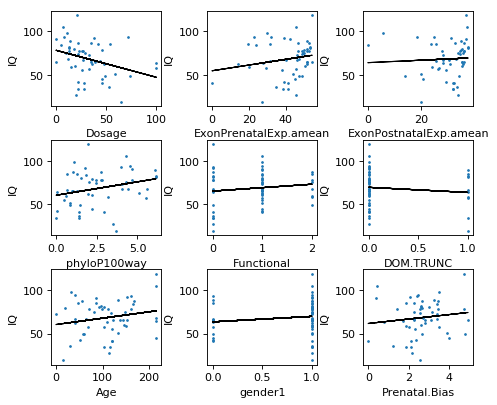

In [170]:
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
features = ["Dosage", "ExonPrenatalExp.amean", "ExonPostnatalExp.amean", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
fig, axs = plt.subplots(3,3,figsize=(6,5), dpi=80,)
axs = axs.flatten()
fig.tight_layout()
models = {}
for ax,feature in zip(axs, features):  
    X = np.reshape(df[feature].values, (-1,1))
    X = max(X) - X
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    slope = regr.coef_[0][0]
    intercept = regr.intercept_[0]
    y_pred = regr.predict(X) 
    models[feature] = regr
    ax.scatter(X, Y, s=2)
    #ax.scatter(y_pred, Y, s=2)
    if feature == "Dosage":
        ax.plot(np.append(X, [0]), np.append(y_pred, intercept), color='black', linewidth=1)
        #ax.plot(np.append(100, [0]), np.append(100, 0), color='red', linewidth=1)
    else:
        ax.plot(np.append(X, [0]), np.append(y_pred, intercept), color='black', linewidth=1)
    #    ax.plot(np.append(X, [0]), np.append(y_pred, intercept), color='black', linewidth=1)
    ax.set_ylabel("IQ")
    ax.set_xlabel(feature)
plt.show()

In [171]:
df, pred_dosage, pred_gene, pred_mean, IQs = DosageModel(Jiayao_features, plot=False)
TSS = sum([(x-y)**2 for x,y in zip(IQs, pred_mean)])
print("TSS:",TSS,len(IQs)*np.var(IQs))
ESS = sum([(x-y)**2 for x,y in zip([np.mean(pred_dosage)]*len(pred_dosage), pred_dosage)])
SSR = sum([(x-y)**2 for x,y in zip(IQs, pred_dosage)])
print("R2", ESS/TSS, 1-SSR/TSS)
SSE_Dosage = sum([(x-y)**2 for x,y in zip(pred_dosage, IQs)])
SSE_Gene = sum([(x-y)**2 for x,y in zip(pred_gene, IQs)])
SSE_Mean = sum([(x-y)**2 for x,y in zip(pred_mean, IQs)])
print(SSE_Dosage, SSE_Gene, SSE_Mean)
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
#const = np.reshape(  np.ones(X.shape[0]),(-1,1))
#X = np.hstack((const, X))
features = ["Dosage", "ExonPrenatalExp.amean", "ExonPostnatalExp.amean", "phyloP100way", "Functional", "DOM.TRUNC"]
#print("%20s\t%8s\t%8s\t%8s\t%8s\t%8s"%("feature", "pearsonr", "P_corr", "R2_gene", "R2_mean", "Err"))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit()
#X = models["Dosage"].predict(X)
pred = res.predict(X)
r, p = pearsonr(np.array(Jiayao_features["Dosage"]), np.array(Jiayao_features["NVIQ"]))
r1, p1 = pearsonr(X, Y)
SSR = sum([(x-y)**2 for x,y in zip(X, IQs)])
R2_gene = 1- SSR/SSE_Gene
R2_mean = 1- SSR/TSS
#R2_mean = 1- SSR/TSS
print("%20s\t%8.3f\t%8.3f\t%8.3f\t%8.3f"%("Dosage", r1, r1**2, R2_mean, R2_gene))

for feature in features[1:7]:
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    if feature == "Dosage":
        #x = x
        x = models[feature].predict(x)
    else:
        x = max(x) - x
        #x = models[feature].predict(x)
    X = np.hstack((X, x))
    #r, p = spearmanr(x, Y)
    r, p = pearsonr(x, Y)
    glm = sm.GLM(Y, x, family=sm.families.Gaussian())
    res = glm.fit()
    pred = res.predict(x)
    SSR = sum([(x-y)**2 for x,y in zip(IQs, x)])
    R2_gene = 1- SSR/SSE_Gene
    R2_mean = 1- SSR/TSS
    print("%20s\t%8.3f\t%8.3f\t%8.3f\t%8.3f"%(feature, r, r**2, R2_mean, R2_gene))
    #print("%20s\t%8.3f\t%8.2e\t%8.4f\t%8.4f\t%8.4f"%(feature, r, p, R2_gene, R2_mean, PredErrMedian(pred, Y)))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="IRLS", max_start_irls=6)
pred = res.predict(X)
print(res.summary())

TSS: 22195.75 22195.75
R2 1.126780137073236 -0.42922280553367065
31722.67208592397 31307.05555555556 22195.75
              Dosage	   0.329	   0.108	  -0.429	  -0.013
ExonPrenatalExp.amean	   0.188	   0.035	  -1.833	  -1.008
ExonPostnatalExp.amean	   0.053	   0.003	  -3.533	  -2.214
        phyloP100way	   0.259	   0.067	 -10.068	  -6.847
          Functional	   0.131	   0.017	 -10.649	  -7.258
           DOM.TRUNC	  -0.112	   0.013	 -10.856	  -7.406
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   52
Model:                            GLM   Df Residuals:                       46
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          460.81
Method:                          IRLS   Log-Likelihood:                -230.05
Date:                Mon, 08 Jul 2019   Deviance:                      

(52, 33)
[(0, 9), (10, 19), (20, 29), (30, 39), (40, 52)]


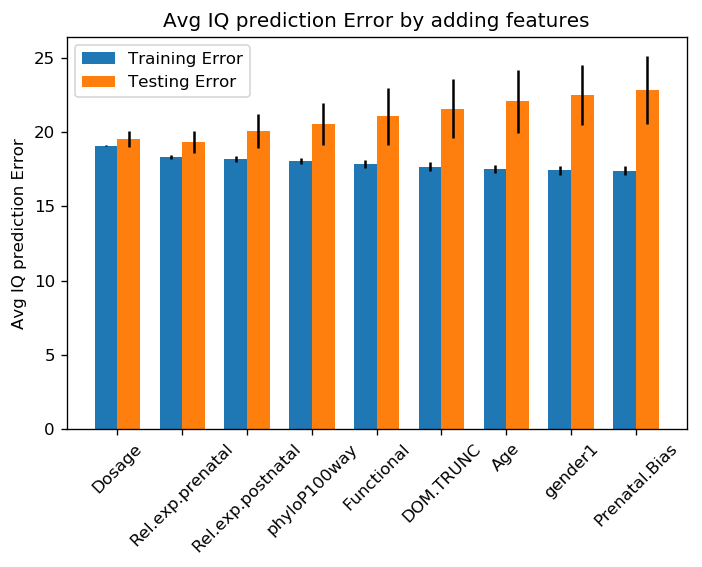

In [173]:
Error = "mean"
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
#Jiayao_features = Jiayao_features[Jiayao_features["gender"]=="M"]
#Jiayao_features = Jiayao_features[~Jiayao_features["familyId"].isin(FamExclude)]
Jiayao_features = Jiayao_features.sample(frac=1).reset_index(drop=True)
print(Jiayao_features.shape)
Fold = 5
step = int(Jiayao_features.shape[0]/Fold)
Splits = [(i*step, i*step+step-1) for i in range(Fold-1)] + [((Fold-1)*step, Jiayao_features.shape[0])]
#Splits = [(0,9), (10,19), (20,29), (30, 39), (40, 52)]
print(Splits)
features = ["Dosage", "Rel.exp.prenatal", "Rel.exp.postnatal", "phyloP100way", "Functional", "DOM.TRUNC", 
            "Age", "gender1", "Prenatal.Bias"]
Addfeatures = []
Fold = 5
TrainingErr, TrainingErrConf = [],[]
TestingErr, TestingErrConf = [],[]
for feature in features:
    Addfeatures.append(feature)
    Scores_Train, Scores_Test = CrossVal(Jiayao_features, Splits, Addfeatures, Error=Error)
    TrainingErr.append(np.mean(Scores_Train))
    Scores_Train = sorted(Scores_Train)
    #TrainingErrConf.append(np.std(Scores_Train)  / math.sqrt(100))
    TrainingErrConf.append(abs(Scores_Train[5] - Scores_Train[95])/2)
    TestingErr.append(np.mean(Scores_Test))
    Scores_Test = sorted(Scores_Test)
    #TestingErrConf.append(np.std(Scores_Test)  / math.sqrt(100))
    TestingErrConf.append(abs(Scores_Test[5] - Scores_Test[95])/2)
    #print(", ".join(Addfeatures))
    #print("Training Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Train), np.std(Scores_Train) * 2))
    #print("Testing Err(mean): %0.2f (+/- %0.2f)" % (np.mean(Scores_Test), np.std(Scores_Test) * 2))
    #print()
ind = np.arange(len(features))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, TrainingErr, width, yerr=TrainingErrConf,
                label='Training Error')
rects2 = ax.bar(ind + width/2, TestingErr, width, yerr=TestingErrConf,
                label='Testing Error')
ax.set_ylabel('Avg IQ prediction Error')
ax.set_title('Avg IQ prediction Error by adding features')
ax.set_xticks(ind)
ax.set_xticklabels(features)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=45)
plt.show()

13890-21:38865466 DYRK1A 42.0 89.78203338509266 0.8686728280512421
13256-21:38877892 DYRK1A 85.0 14.855858040216418 1.2752138377276143
10


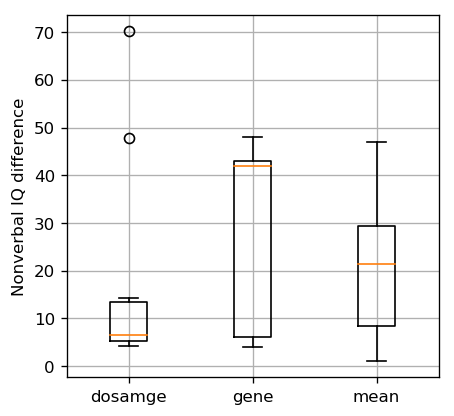

MannwhitneyuResult(statistic=39.0, pvalue=0.21350375154221196)
MannwhitneyuResult(statistic=42.0, pvalue=0.2843543114604846)
Mean:	Dosage:17.656	Gene:28.600	Mean:20.140
Median:	Dosage:6.507	Gene:42.000	Mean:21.500


AttributeError: 'tuple' object has no attribute 'shape'

In [174]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["Age"]>=144]
df = DosageModel(Jiayao_features)
print(df.shape[0])
#df = df[abs(df["Dosage"] - df["NVIQ"]) < 30]
print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
GLMs.append(res)
pred = res.predict(X)
for feature in []:#["Rel.exp.prenatal", "Rel.exp.postnatal",
               #"phyloP100way", "Functional", "DOM.TRUNC"]:#, #"gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
print(PredErrMedian(pred, Y))
print(res.summary())

13900-14:21895990 CHD8 27.0 76.30643960003607 0.672300850348769
11403-3:71026115 FOXP1 64.0 0 2.879538174647055
12817-3:71050171 FOXP1 34.0 77.82006481693614 1.77411027974527
12952-7:104748101 MLL5 58.0 0 1.4159638594755717
35


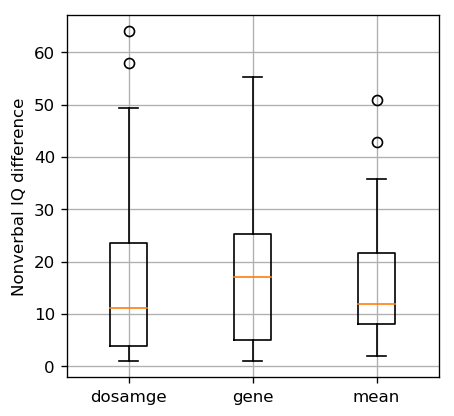

MannwhitneyuResult(statistic=541.0, pvalue=0.20210916303601362)
MannwhitneyuResult(statistic=528.5, pvalue=0.16316601357950006)
Mean:	Dosage:16.516	Gene:17.586	Mean:16.220
Median:	Dosage:11.065	Gene:17.000	Mean:11.857


AttributeError: 'tuple' object has no attribute 'shape'

In [175]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.52.csv")
Jiayao_features = Jiayao_features[Jiayao_features["gender"]=='M']
df = DosageModel(Jiayao_features)
print(df.shape[0])
#df = df[abs(df["Dosage"] - df["NVIQ"]) < 30]
#print(df.shape[0])
X = np.array(df["Dosage"].values)
X = np.reshape(X, (-1,1))
const = np.reshape(  np.ones(X.shape[0]),(-1,1))
X = np.hstack((const, X))
Y = np.reshape(np.array(df["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit(method="Newton")
GLMs.append(res)
pred = res.predict(X)
for feature in ["Rel.exp.prenatal", "Rel.exp.postnatal",
                "phyloP100way", "Functional", "DOM.TRUNC", "Age", "gender1", "Prenatal.Bias"]:
    r, p = spearmanr(np.array(df[feature].values), np.array(df["NVIQ"].values))
    x = np.array(df[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    GLMs.append(res)
    pred = res.predict(X)
print(PredErrMean(pred, Y))
print(res.summary())

In [176]:
Jon_features = pd.read_csv("unifiedmodel/model-features.csv")
Jon_features = Jon_features[~Jon_features["KEY"].isin(ExcludeList)]
Jon_features.head()

,KEY,ENTREZ,NVIQ,PRED,AGE,GEND,DOM.TRUNC,DOM.TRUNC.FRAC,PRENATAL,POSTNATAL,DEV.BIAS,CONSERV,FUNC
0,12645-4:114232545,287,84,4.928226,51.0,M,True,0.40,0.871835,1.098588,-0.333523,2.840792,NEUR
1,13768-4:114277600,287,94,7.530656,176.0,M,True,0.20,0.894915,0.575636,0.636595,1.621037,NEUR
2,14256-4:114251469,287,98,11.144313,183.0,M,True,0.40,0.699788,0.939402,-0.424824,3.604094,NEUR
3,13614-15:93563244,1106,81,13.164656,113.0,M,False,0.00,0.209119,0.150609,0.473517,3.270302,DEV
4,13618-15:93524061,1106,49,73.382222,159.0,F,True,0.25,0.813168,0.610889,0.412643,4.175000,DEV


In [177]:
def mapgender(row):
    if row["GEND"] == "M": 
        return 1
    elif row["GEND"] == "F":
        return 2
def mapfunc(row):
    if row["FUNC"] == "NEUR": 
        return 1
    elif row["FUNC"] == "DEV":
        return 2
    else:
        return 0
def mapdomain(row):
    if row["DOM.TRUNC"] == True: 
        return 1
    elif row["DOM.TRUNC"] == False:
        return 2
Jon_features["GEND2"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
Jon_features["FUNC2"] = Jon_features.apply(lambda row:mapfunc(row), axis=1)
Jon_features["DOM.TRUNC2"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
#Jon_features["effectGene"] = Jon_features.apply(lambda row:mapgender(row), axis=1)
Jon_features.head()

,KEY,ENTREZ,NVIQ,PRED,AGE,GEND,DOM.TRUNC,DOM.TRUNC.FRAC,PRENATAL,POSTNATAL,DEV.BIAS,CONSERV,FUNC,GEND2,FUNC2,DOM.TRUNC2
0,12645-4:114232545,287,84,4.928226,51.0,M,True,0.40,0.871835,1.098588,-0.333523,2.840792,NEUR,1,1,1
1,13768-4:114277600,287,94,7.530656,176.0,M,True,0.20,0.894915,0.575636,0.636595,1.621037,NEUR,1,1,1
2,14256-4:114251469,287,98,11.144313,183.0,M,True,0.40,0.699788,0.939402,-0.424824,3.604094,NEUR,1,1,1
3,13614-15:93563244,1106,81,13.164656,113.0,M,False,0.00,0.209119,0.150609,0.473517,3.270302,DEV,1,2,1
4,13618-15:93524061,1106,49,73.382222,159.0,F,True,0.25,0.813168,0.610889,0.412643,4.175000,DEV,2,2,2


69.08928571428571
(56, 16)
13900-14:21895990 57680 27 82.62766745934226 0.4550057791595517
14233-14:21859176 57680 19 82.62766745934226 0.4550057791595517


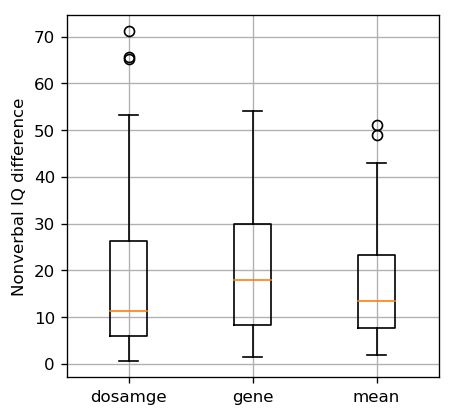

32945.050721714324 31307.055555555555 22232.37882653062
52 -0.4818500070896563 -0.40817389807139426 -0.05232032003942644


In [178]:
IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
SSE1, SSE2, SSE3 = 0,0,0
avg_IQ = np.mean(Jon_features["NVIQ"].values)
print(avg_IQ)
N = 0
ExcludeList = []
print(Jon_features.shape)
for i, row in Jon_features.iterrows():
    familyId, gene, pred, IQ = row["KEY"], row["ENTREZ"], row["PRED"], row["NVIQ"]
    df = Jon_features[(Jon_features["ENTREZ"]==gene) & (Jon_features["KEY"]!=familyId)]
    if len(df["NVIQ"].values)<1:
        #print(gene)
        continue
    if abs(IQ - IQpre_dosage) > 50:
        print(row["KEY"], gene, IQ, IQpre_dosage, ralexp)
        #Variants.at[i, "Dosage"] = IQpre_dosage
        #ExcludeList.append(familyId)
        #continue
    IQpre_gene = np.mean(df["NVIQ"].values)
    IQ_diff1.append(abs(IQ - (100-pred)))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - 70))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1
plt.figure(figsize=(4,4), dpi=120)
plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
plt.ylabel("Nonverbal IQ difference")
plt.grid(True)
plt.show()
print(SSE1, SSE2, SSE3)
print(N, (1-SSE1/SSE3),(1-SSE2/SSE3),(1-SSE1/SSE2))

In [179]:
print("%20s\t%8s\t%8s\t%8s\t%.8s"%("feature", "spearmanr", "P_corr", "R2_gene", "R2_mean"))
X = np.array(Jon_features["PRED"].values)
X = np.reshape(X, (-1,1))
Y = np.reshape(np.array(Jon_features["NVIQ"].values), (-1, 1))
glm = sm.GLM(Y, X, family=sm.families.Gaussian())
res = glm.fit()
pred = res.predict(X)
r, p = spearmanr(np.array(Jon_features["PRED"]), np.array(Jon_features["NVIQ"]))
R2_gene = 1- SSE(pred, Y)/SSE2
R2_mean = 1- SSE(pred, Y)/SSE3
print("%20s\t%8.3f\t%8.2e\t%8.4f\t%.8f"%("PRED", r, p, R2_gene, R2_mean))
for feature in ["PRENATAL","POSTNATAL","DEV.BIAS","CONSERV","GEND2","FUNC2","DOM.TRUNC2"]:
    r, p = spearmanr(np.array(Jon_features[feature].values), np.array(Jon_features["NVIQ"].values))
    x = np.array(Jon_features[feature].values)
    x = np.reshape(x, (-1,1))
    X = np.hstack((X, x))
    glm = sm.GLM(Y, X, family=sm.families.Gaussian())
    res = glm.fit()
    pred = res.predict(X)
    R2_gene = 1- SSE(pred, Y)/SSE2
    R2_mean = 1- SSE(pred, Y)/SSE3
    print("%20s\t%8.3f\t%8.2e\t%8.4f\t%.8f"%(feature, r, p, R2_gene, R2_mean))

             feature	spearmanr	  P_corr	 R2_gene	R2_mean
                PRED	  -0.373	4.64e-03	  0.9232	0.89190643
            PRENATAL	  -0.196	1.48e-01	  0.9412	0.91722693
           POSTNATAL	  -0.101	4.61e-01	  0.9521	0.93254816
            DEV.BIAS	  -0.077	5.73e-01	  0.9600	0.94364778
             CONSERV	  -0.310	1.99e-02	  0.9748	0.96453596
               GEND2	  -0.164	2.28e-01	  0.9769	0.96743469
               FUNC2	  -0.113	4.06e-01	  0.9769	0.96743622
          DOM.TRUNC2	  -0.164	2.28e-01	  0.9769	0.96743622


In [180]:
Jon_keys = set(Jon_features["KEY"].values)
Jiayao_keys = set(Jiayao_features["KEY"].values)
print(Jon_keys.difference(Jiayao_keys))
print(Jiayao_keys.difference(Jon_keys))
common_keys = Jon_keys.intersection(Jiayao_keys)
print(len(common_keys))

{'12681-12:13722953', '13796-2:162275482', '13903-9:96437988', '11654-14:21871373', '12752-14:21861377', '14200-10:28879674', '12090-10:114910883', '13905-16:89351043', '14030-2:183866862', '13890-21:38865466', '11114-2:166210819', '11872-18:44603833', '14204-10:28899669', '12418-1:202705466', '13618-15:93524061', '14393-6:157510806'}
set()
40


In [181]:
Jiayao_features_common = Jiayao_features[Jiayao_features["KEY"].isin(common_keys)]
for row in Jiayao_features_common.iterrows():
    familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.amean"], row["NVIQ"]
    #familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["Rel.exp.prenatal"], row["NVIQ"]
    df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
    IQs = df["NVIQ"].values
    IQDiffs = [max(0, (100-x)) for x in IQs]
    rel_exps = [x for x in df["Rel.exp.amean"].values]
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    regr = regGene(rel_exps, IQDiffs)
    slope = regr.coef_[0]
    IQpre_dosage = max(0, (100 - slope * ralexp))

    IQpre_gene = np.mean(IQs)
    if abs(IQ - IQpre_dosage) > 50:
        print(familyId, IQ, IQpre_dosage, ralexp)
        Variants.at[i, "Dosage"] = IQpre_dosage
        ExcludeList.append(familyId)
        continue
    Variants.at[i, "Dosage"] = IQpre_dosage
    IQ_diff1.append(abs(IQ - IQpre_dosage))
    IQ_diff2.append(abs(IQ - IQpre_gene))
    IQ_diff3.append(abs(IQ - avg_IQ))
    SSE1 += (IQ - IQpre_dosage) ** 2
    SSE2 += (IQ - IQpre_gene) ** 2
    SSE3 += (IQ - avg_IQ) ** 2
    N += 1

TypeError: tuple indices must be integers or slices, not str

In [182]:
Jon_features["famid"] = Jon_features.apply(lambda row:int(row["KEY"].split("-")[0]), axis=1)
Jon_features[Jon_features["famid"].isin(ExcludeList)]

,KEY,ENTREZ,NVIQ,PRED,AGE,GEND,DOM.TRUNC,DOM.TRUNC.FRAC,PRENATAL,POSTNATAL,DEV.BIAS,CONSERV,FUNC,GEND2,FUNC2,DOM.TRUNC2,famid


In [183]:
Jiayao_features[Jiayao_features["familyId"].isin(ExcludeList)]

,KEY,familyId,vcfVariant,inChild,effectGene,effectType,gender,FSIQ,VIQ,NVIQ,...,Rel.exp.gmean,Rel.exp.prenatal,Rel.exp.postnatal,Prenatal.Bias,phyloP100way,phastCons100way,gender1,Age,Dosage,GeneCount


In [184]:
print(ExcludeList)

[]


/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/jiayao/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


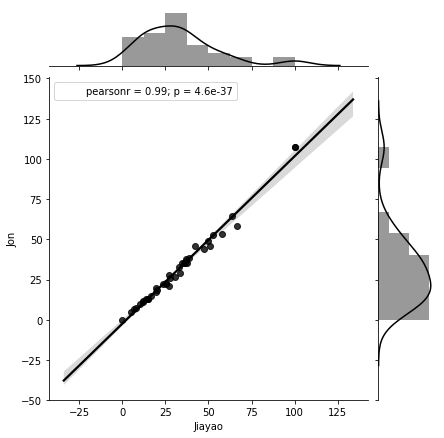

In [185]:
PredCor = []
Jiayao_pre = []
Jon_pre = []
for key in common_keys:
    Jiayao_pre.append(100-Jiayao_features[Jiayao_features["KEY"]==key]["Dosage"].values[0])
    Jon_pre.append(Jon_features[Jon_features["KEY"]==key]["PRED"].values[0])
    
j = sns.jointplot(x=Jiayao_pre, y=Jon_pre, kind='reg', color="black")
j.annotate(pearsonr)
plt.xlabel("Jiayao")
plt.ylabel("Jon")
plt.show()

In [311]:
#SameExonIQ
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
SSC_LGD = pd.read_csv("unifiedmodel/SSC.LGD.features.csv")
DF = Jiayao_features
#DF = SSC_LGD.dropna()
#DF = DF[(DF["FSIQ"]!=-1) & (DF["VABS"]!=-1)]
#Jiayao_features["VABS"] = Jiayao_features.apply(lambda row:indv2vabs.get(row["familyId"], np.nan), axis=1)

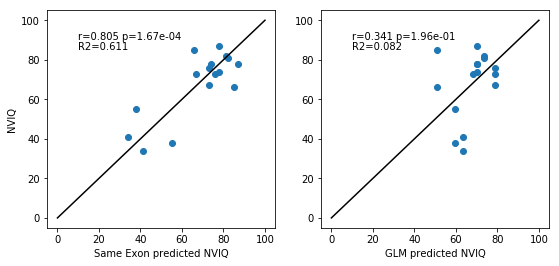

In [316]:
SameExonPredictions, SameExonTarget, SameExonPredictErr, NewSameExon = SameExonPred(DF, "NVIQ")
res1, GLM_err1, pred_test1, Y_test1 = llllll(True, DF, NewSameExon, "NVIQ")
PlotScatter4R2(SameExonPredictions, SameExonTarget,pred_test1,Y_test1,"NVIQ")

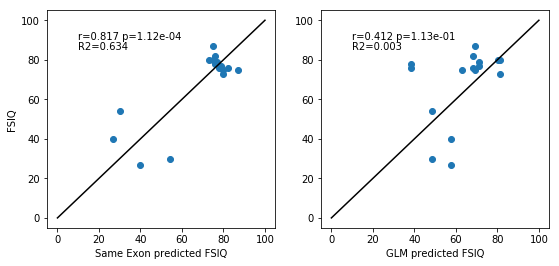

In [317]:
SameExonPredictions, SameExonTarget, SameExonPredictErr, NewSameExon = SameExonPred(DF, "FSIQ")
res1, GLM_err1, pred_test1, Y_test1 = llllll(True, DF, NewSameExon, "FSIQ")
PlotScatter4R2(SameExonPredictions, SameExonTarget,pred_test1,Y_test1,"FSIQ")

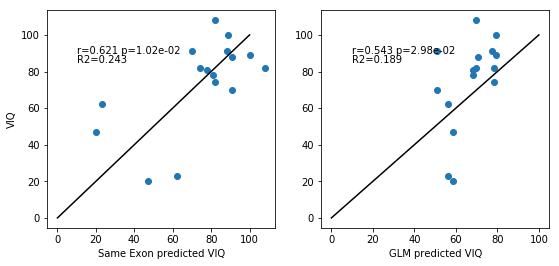

In [318]:
SameExonPredictions, SameExonTarget, SameExonPredictErr, NewSameExon = SameExonPred(DF, "VIQ")
res1, GLM_err1, pred_test1, Y_test1 = llllll(True, DF, NewSameExon, "VIQ")
PlotScatter4R2(SameExonPredictions, SameExonTarget,pred_test1,Y_test1,"VIQ")

6.875
5.211168323889446


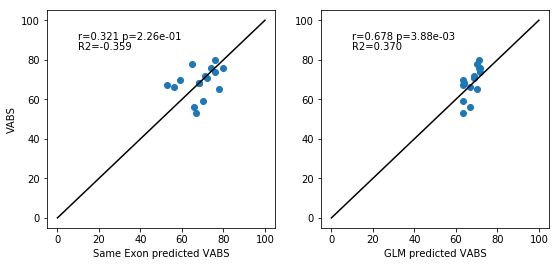

In [323]:
SameExonPredictions, SameExonTarget, SameExonPredictErr, NewSameExon = SameExonPred(DF, "VABS")
print(np.mean(SameExonPredictErr))
res1, GLM_err1, pred_test1, Y_test1 = llllll(True, DF, NewSameExon, "VABS")
print(np.mean(GLM_err1))
PlotScatter4R2(SameExonPredictions, SameExonTarget,pred_test1,Y_test1,"VABS")

In [321]:
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:                            GLM   Df Residuals:                       43
Model Family:                Gaussian   Df Model:                            5
Link Function:               identity   Scale:                          128.19
Method:                          IRLS   Log-Likelihood:                -185.24
Date:                Mon, 08 Jul 2019   Deviance:                       5512.0
Time:                        20:48:34   Pearson chi2:                 5.51e+03
No. Iterations:                     3   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         77.7997      6.479     12.009      0.000      65.102      90.498
x1            -0.1476      0.149     -0.990      0.322      -0.440       0.145
x2             0.1095      0.208      0.527      0.598      -0.298       0.517
x3            -1.5007      1.002     -1.498      0.134      -3.464       0.463
x4            -2.6849      2.330     -1.152      0.249      -7.251       1.881
x5             0.0577      4.401      0.013      0.990      -8.569       8.684
==============================================================================
"""